In [1]:
%load_ext autoreload
%autoreload 2

import collections
import logging 
import math
import itertools
import random
import warnings
warnings.filterwarnings('ignore')

import Bio
from Bio import Seq, SeqIO
import logomaker
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats


log = logging.getLogger()
WT = 'GCACAGGCGCAGACCGGCTGG'
tab10 = matplotlib.cm.get_cmap('tab10')
def set_pltrc():
    plt.rcParams["font.family"] = 'Helvetica'
    plt.rcParams['font.size'] = 9
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['figure.constrained_layout.use'] = True
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['figure.facecolor'] = 'w'
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['agg.path.chunksize'] = 10000
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)

set_pltrc()
def translate(s):
    return str(Seq.Seq(s).translate(table="Standard"))

def load_run_variants(run, construct, filename=None, load_all=False, num_bp=None, dtypes=None, sort_by=None,
                      sample_rename_fn=None):
    num_bp = num_bp if num_bp else 21
    sort_by = sort_by if sort_by is not None else 'rpm_ratio'
    variants_columns = ['sample', 'seq', 'num_reads', 'rpm', 'rpm_ratio']
    if load_all:
        sub = 'all'
    else:
        sub = 'filtered'

    df_dtypes = {'sample': 'category'}
    if dtypes is not None:
        df_dtypes.update(dtypes)

    if filename is None:
        filename = f'../runs/{run}/seqvar/{run}.{construct}.{sub}_variants.tsv.gz'

    df = pd.read_csv(filename, sep='\t', names=variants_columns, dtype=df_dtypes)

    df = df.sort_values(sort_by, ascending=False)
    df['tissue'] = df['sample'].str.split('_').str[-2].astype('category')
    df['nucl'] = df['sample'].str.split('_').str[-1].astype('category')
    df['subject'] = df['sample'].str.split('_').str[-3].astype('category')
    df['aa'] = df['seq'].str.pad(width=num_bp, side='right', fillchar='N').map(translate)

    df.loc[df['sample'].str.endswith('vL'), ['tissue', 'subject']] = np.nan
    df.loc[df['sample'].str.endswith('pL'), ['tissue', 'subject']] = np.nan

    if sample_rename_fn is not None:
        df['sample'] = sample_rename_fn(df['sample'])
    df['sample'] = df['sample'].astype('category')
    return df


In [2]:
def plot_sample_ranked_variants(g, ax, ls='--', nucl_type=None, sort_by=None, color=None,
                                specific_variants=None, xmax=None,
                                title=None, title_func=None):
    specific_variants = specific_variants if specific_variants is not None else {WT: {}}
    sort_by = sort_by if sort_by is not None else 'rpm_ratio'
    if sort_by:
        g = g.sort_values(sort_by, ascending=False)
    if nucl_type == 'DNA':
        color = tab10(0)
    elif nucl_type == 'mRNA':
        color = tab10(1)
    p = ax.plot(np.arange(len(g['seq']))+1, g[sort_by], color=color, label=nucl_type)

    rpm_cdf = np.cumsum(g.reset_index()['rpm'])
    if xmax is None and len(g['seq']) > 0:
        cdf_cutoff = 0.95
        rpm_sum = rpm_cdf.iloc[-1]

        if rpm_sum >= cdf_cutoff * 1e6:
            ax.set_xlim([1, rpm_cdf[rpm_cdf.gt(cdf_cutoff * 1e6)].index[0]])

    if specific_variants:
        for specific_variant, props in specific_variants.items():
            color = props.get('color', color)
            if g[g['seq'] == specific_variant].any().any():
                g['nrank'] = g[sort_by].rank(ascending=False)
                variant_rank = g[g['seq'] == specific_variant]['nrank'].iloc[0]
                ax.axvline(variant_rank, color=color, ls=ls, lw=1)

    # Set title=False to omit title
    if title_func is not None:
        ax.set_title(title_func(g.iloc[0]))
    elif title is None:
        ax.set_title(g['sample'].iloc[0])
    elif title:
        ax.set_title(title)
    return ax


def plot_samples_ranked_variants(
        df, nrows=None, ncols=None, samples_perplot=[], figsize=None, title=None, file_title=None,
        sort_by=None, already_sorted=None,
        xmax=None, specific_variants=None, sample_title_func=None):
    sort_by = sort_by if sort_by is not None else 'rpm_ratio'
    ncols = ncols if ncols is not None else 3
    nrows = math.ceil(len(samples_perplot) / ncols)
    figsize = figsize or (8, 2*nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharey='row')
    ax2s = []

    for i, (ax, samples) in enumerate(zip(axs.flat, samples_perplot)):
        ax.set_yscale('log')
        if not isinstance(samples, list):
            samples = [samples]
        for sample_attrs in samples:
            sample_name = sample_attrs.get('sample')
            # Skip if this sample plot position is supposed to be empty (aka wasn't sequenced)
            if not sample_name:
                continue

            sdf = df[df['sample'] == sample_name].copy()
            # Skip plotting this samples without any variants
            if not len(sdf):
                continue
            if not already_sorted:
                sdf = sdf.sort_values(sort_by, ascending=False)
            if 'DNA' in sample_name:
                nucl_type = 'DNA'
            elif 'RNA' in sample_name:
                nucl_type = 'mRNA'
            else:
                nucl_type = 'mRNA'
            ret = plot_sample_ranked_variants(
                sdf, ax, nucl_type=nucl_type, sort_by=sort_by, specific_variants=specific_variants,
                xmax=xmax, title_func=sample_title_func)


        if 'title' in sample_attrs:
            sample_title = sample_attrs['title']
            ax.set_title(sample_title)
        else:
            ax.set_title(sample_name)
        ax.set_xlim(sample_attrs.get('xlim', (-10, 1000)))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(reformat_large_tick_values))
        ax.tick_params(axis='both', which='major', labelsize=7)

    axs[0, 0].legend()
    if sort_by == 'rpm':
        ylabel = 'Variant RPM'
    elif sort_by == 'rpm_ratio':
        ylabel = 'Variant RPM / VL RPM (Pseudocount=1)'
    if ylabel:
        fig.text(-0.02,0.5, ylabel, ha='center', va='center', rotation=90)
    return fig, axs


def default_plot_tissue_variants(
        df, title=None,sort_by=None, xlim=None,
        nrows=None, ncols=None, specific_variants=None, sample_title_func=None,
        **kwargs):
    tissues = sorted(df['tissue'].dropna().unique())
    subjects = sorted(df['subject'].dropna().unique())

    samples_perplot = []
    for t, s in itertools.product(tissues, subjects):
        sample_attrs = {
            'title': '{}: {}'.format(t, s),
        }
        usamples = df[(df['tissue'] == t) & (df['subject'] == s)]['sample'].unique()
        if len(usamples) == 0:
            continue # Empty plot if sample wasn't sequenced

        elif len(usamples) > 1:
            sample_names = usamples

        try:
            sample_name = df[(df['tissue'] == t) & (df['subject'] == s)].iloc[0]['sample']
            sample_attrs['sample'] = sample_name
        except IndexError: # Empty plot if sample wasn't sequenced
            pass
        if xlim is not None:
            sample_attrs['xlim'] = xlim
        if t == 'Heart' or t == 'Liver':
            sample_attrs['xlim'] = (-100, 20000)
        samples_perplot.append(sample_attrs)

    plot_samples_ranked_variants(
        df, nrows=len(tissues), ncols=len(subjects), samples_perplot=samples_perplot,
        title=title, sort_by=sort_by, specific_variants=specific_variants,
        sample_title_func=sample_title_func, **kwargs)

    
def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)

    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")

    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]

    return new_tick_format


In [3]:
def default_plot_tissue_nucl_variants(
        df, samples=None, title=None, sort_by=None,
        nrows=None, ncols=None, specific_variants=None, sample_title_func=None):
    tissues = sorted(df['tissue'].dropna().unique())
    subjects = sorted(df['subject'].dropna().unique())

    samples_perplot = []
    for t, s in itertools.product(tissues, subjects):
        perplot = []
        for nucl in ['mRNA', 'DNA']:
            sample_attrs = {
                'title': '{}: {}'.format(t, s),
            }
            try:
                sample_name = df[(df['tissue'] == t) & (df['subject'] == s) & (df['nucl'] == nucl)].iloc[0]['sample']
                sample_attrs['sample'] = sample_name
            except IndexError: # Empty plot if sample wasn't sequenced
                pass
            if t == 'Heart' or t == 'Liver':
                sample_attrs['xlim'] = (-100, 20000)
            perplot.append(sample_attrs)
        samples_perplot.append(perplot)

    plot_samples_ranked_variants(
        df, nrows=len(tissues), ncols=len(subjects), samples_perplot=samples_perplot,
        title=title, sort_by=sort_by, specific_variants=specific_variants,
        sample_title_func=sample_title_func)

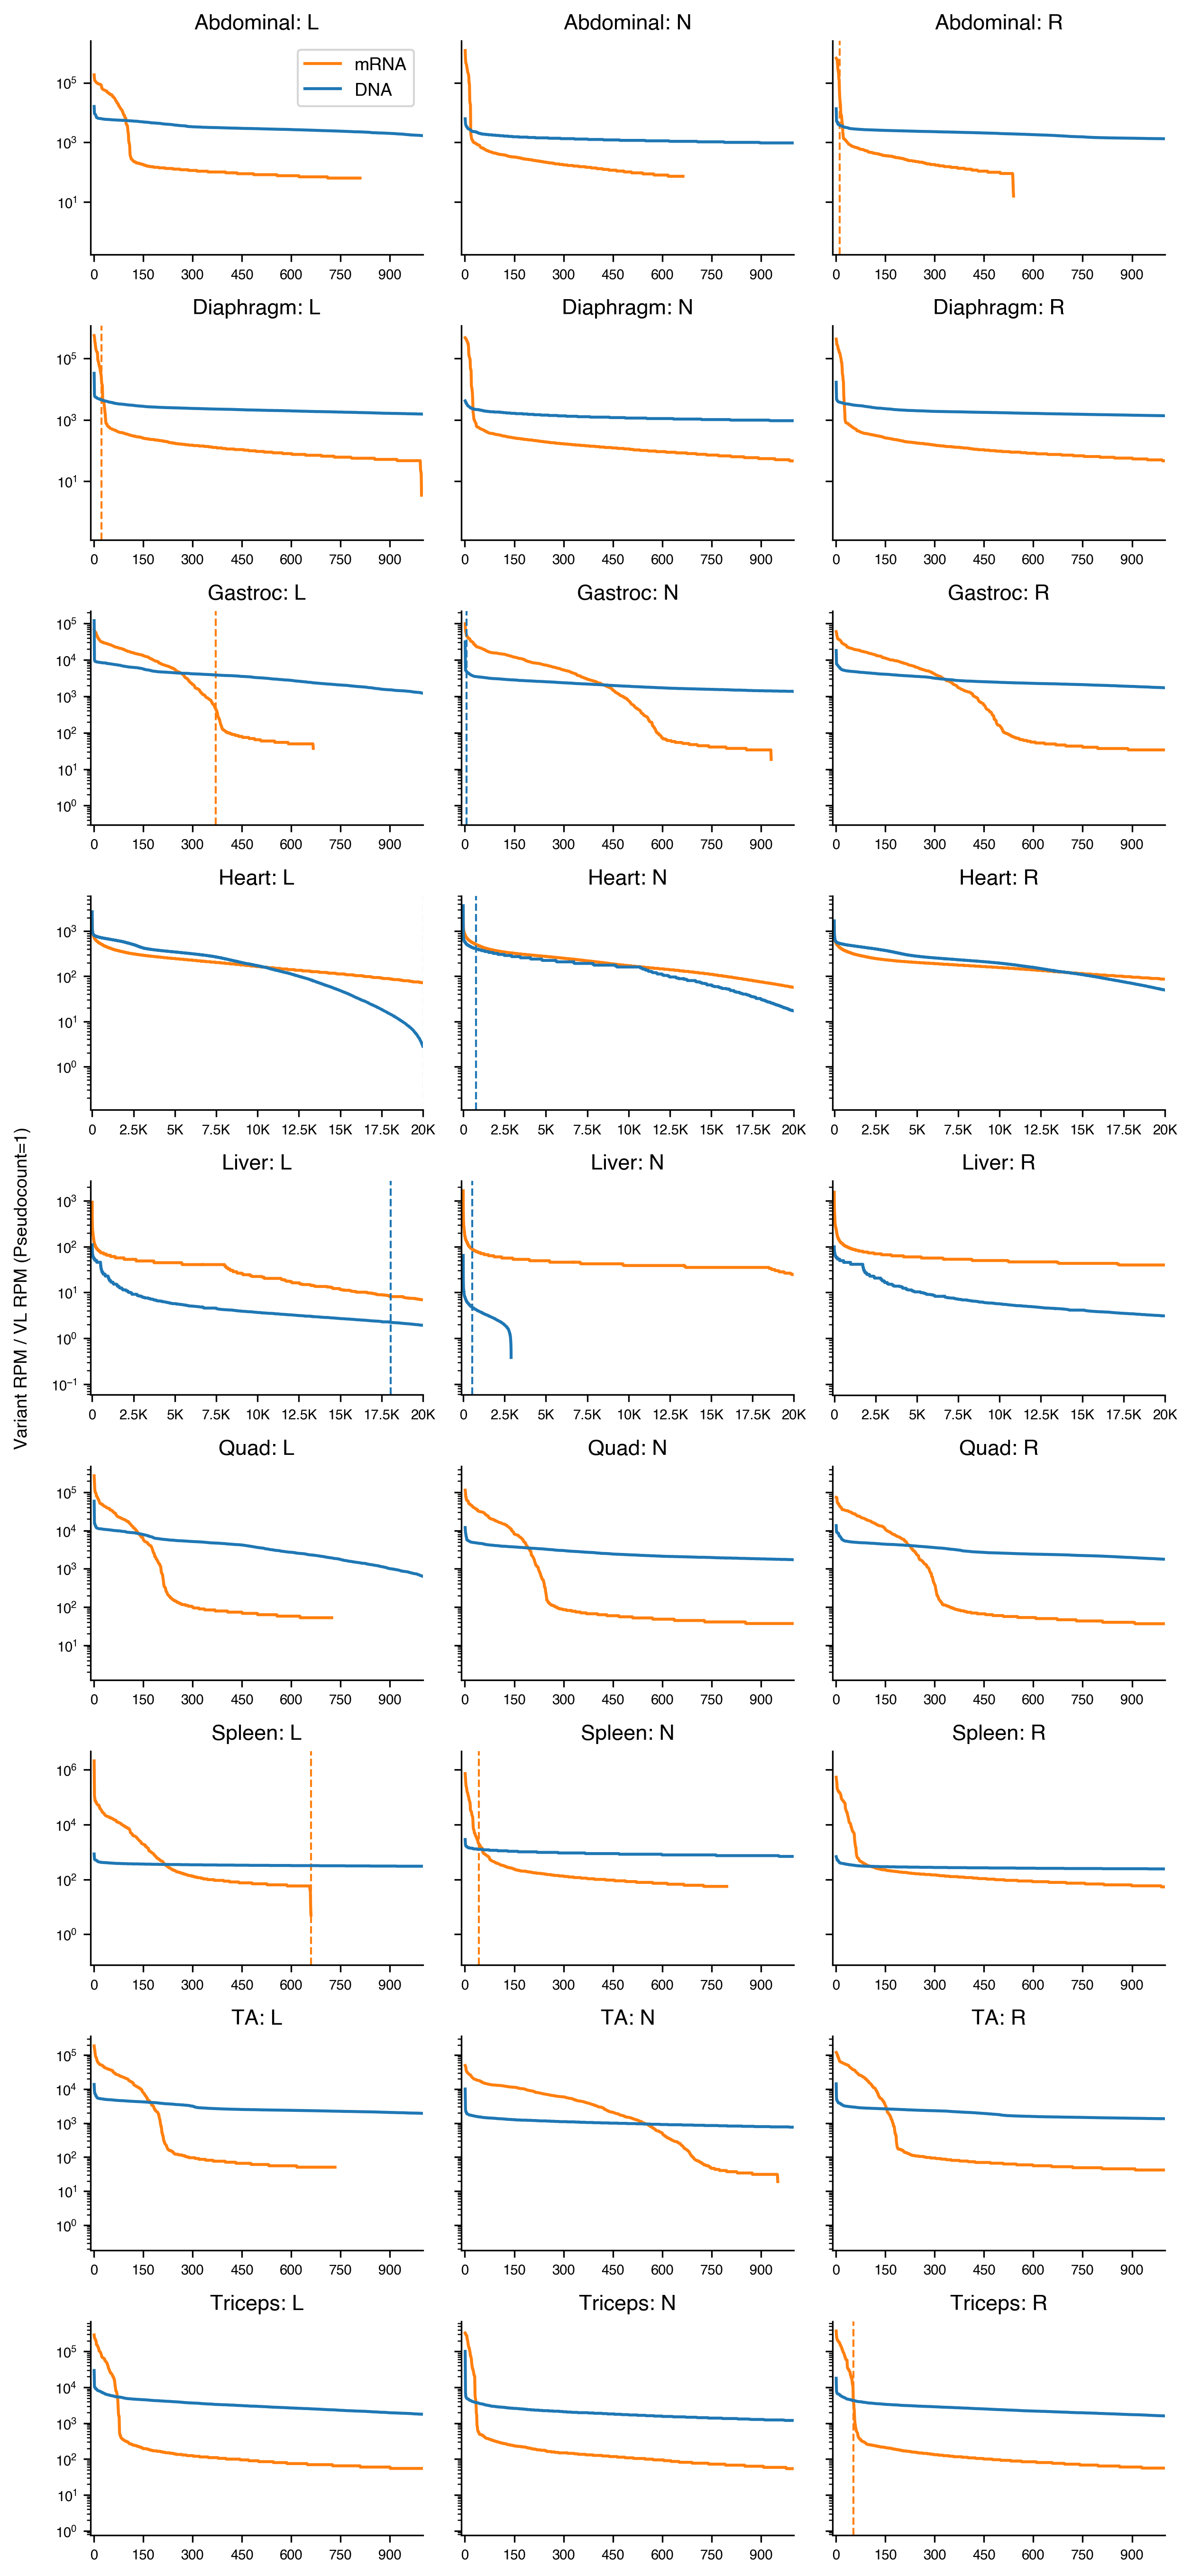

In [4]:
mhck7 = load_run_variants('190607', 'gSB118')
default_plot_tissue_nucl_variants(mhck7, sort_by='rpm_ratio')

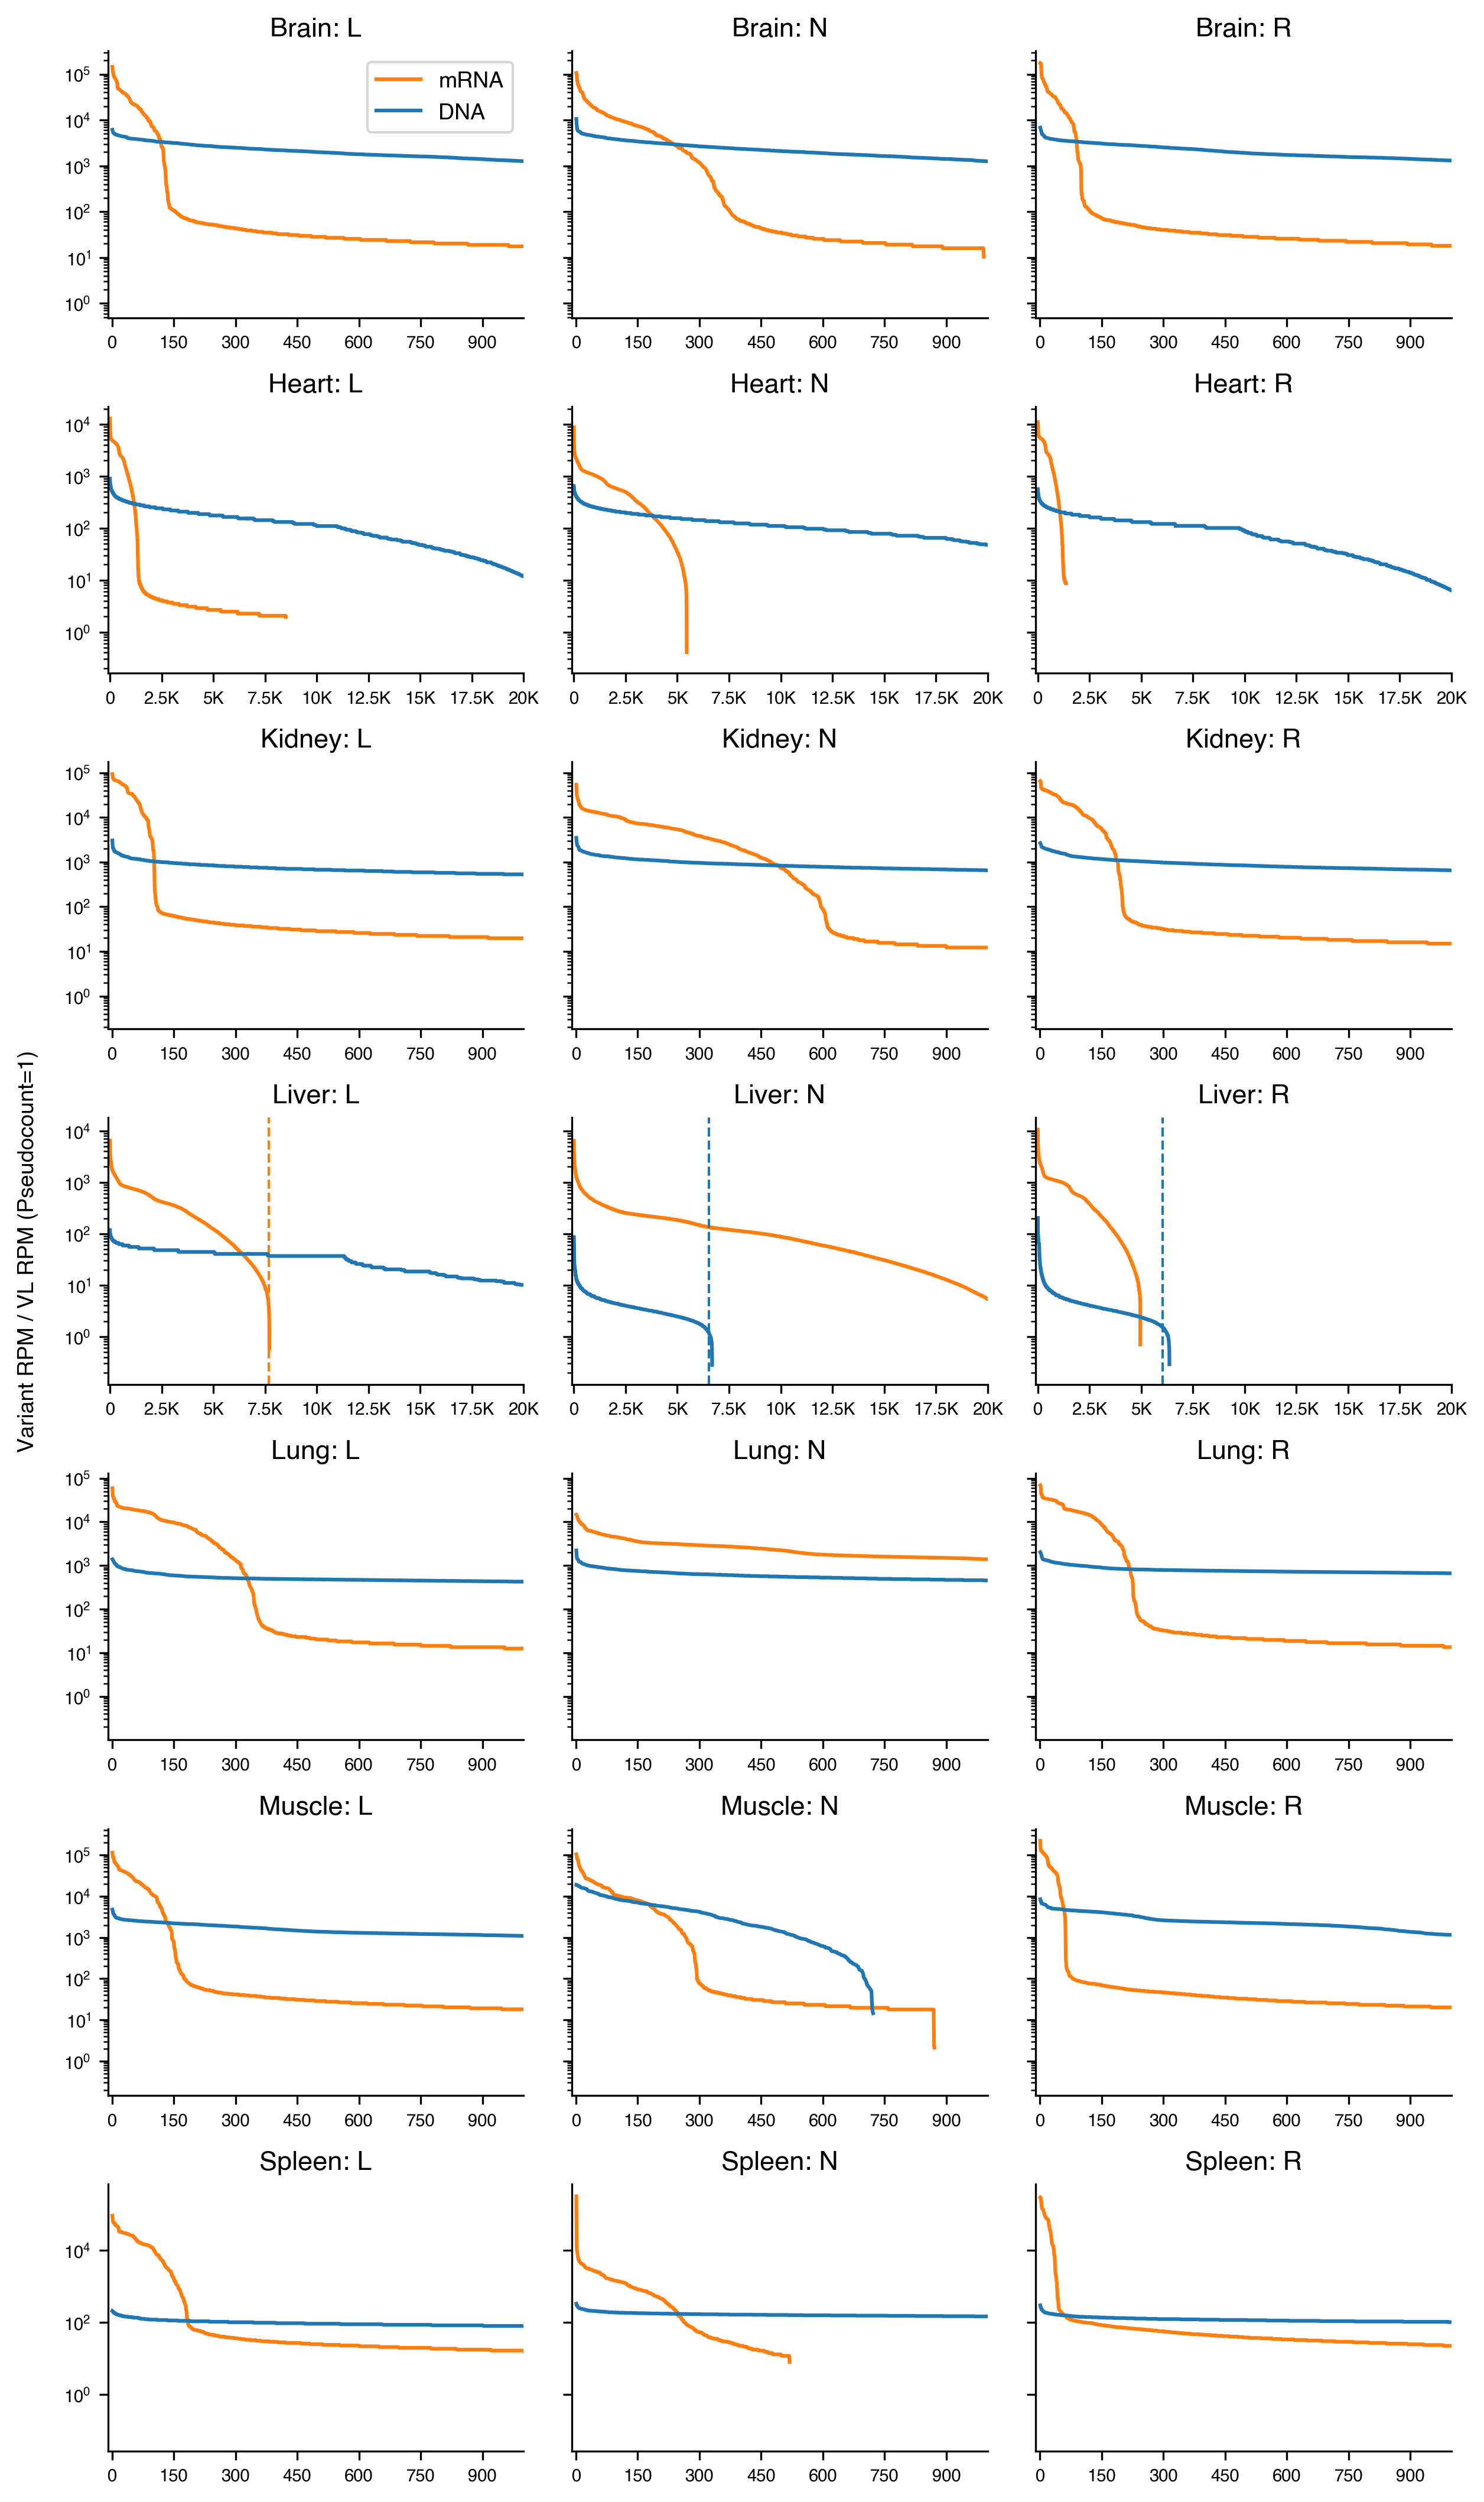

In [5]:
cmv = load_run_variants('190613', 'gSB114')
default_plot_tissue_nucl_variants(cmv, sort_by='rpm_ratio')

In [6]:
liver_mrna = cmv[cmv['sample'] == 'gSB114_L_Liver_mRNA']
liver_dna = cmv[cmv['sample'] == 'gSB114_L_Liver_DNA']
cmv_vl = cmv[cmv['sample'] == 'gSB114_vL']

Text(0, 0.5, 'Liver RPM')

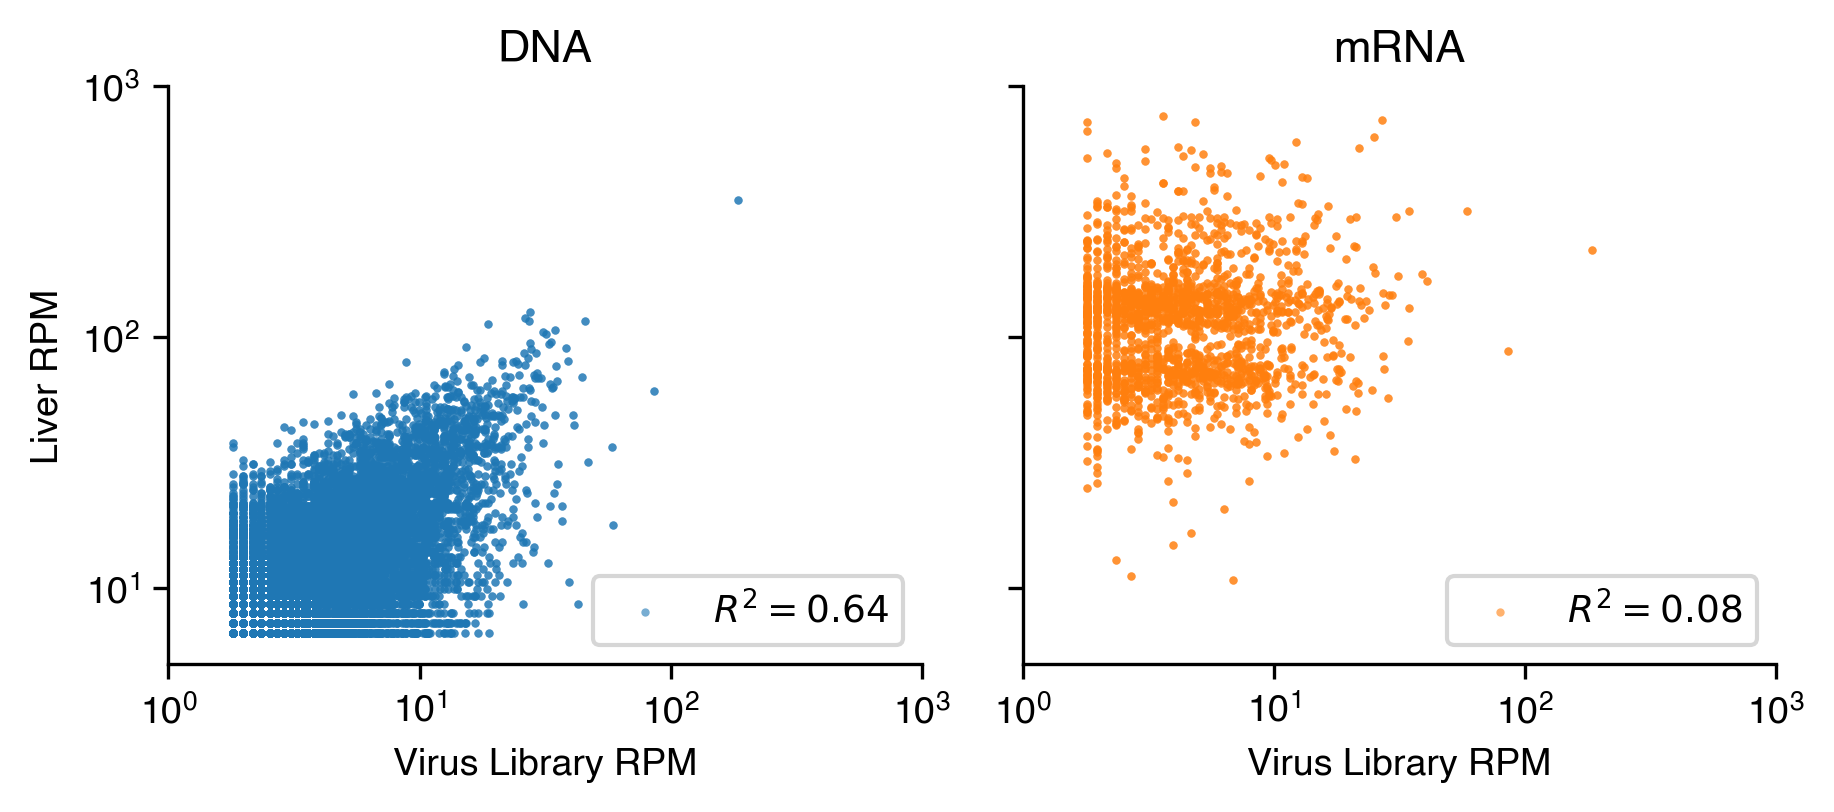

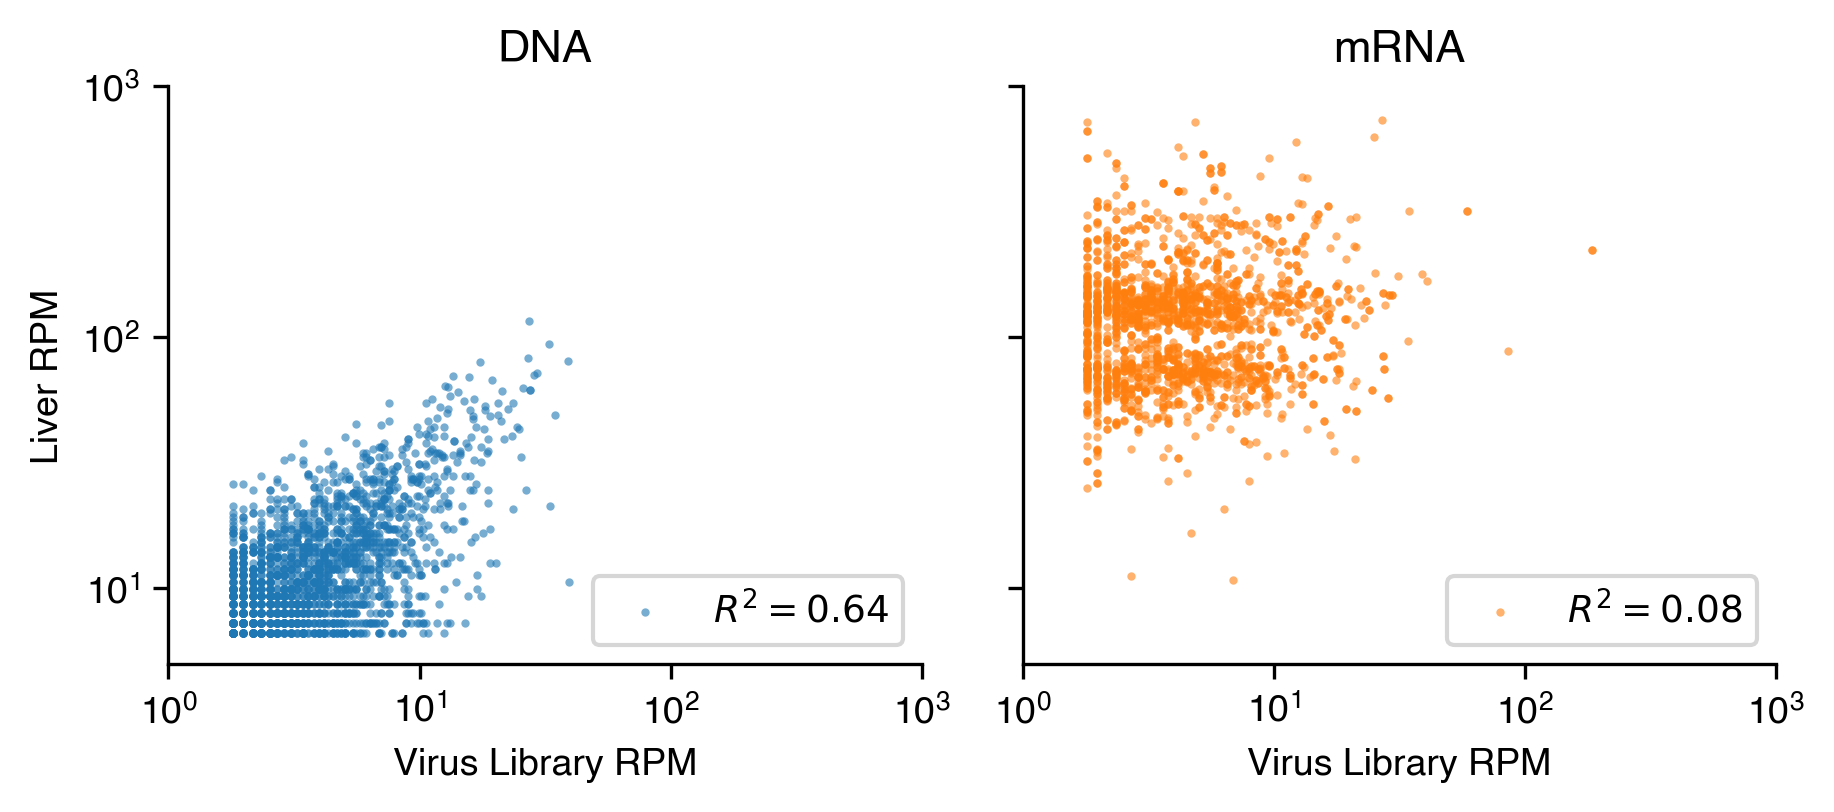

In [7]:
dnavl = liver_dna.merge(cmv_vl, on='seq', suffixes=('', '_vl'))[['seq', 'rpm', 'rpm_vl']]
mrnavl = liver_mrna.merge(cmv_vl, on='seq', suffixes=('', '_vl'))[['seq', 'rpm', 'rpm_vl']]
cmap = plt.get_cmap('tab10')


def scatter_comp(df, ax=None, title=None, color=None, downsample=None):
    ro = scipy.stats.linregress(df['rpm_vl'], df['rpm'])

    if downsample is not None:
        idx = random.sample(range(len(df)), min(len(df), downsample))
        df = df.loc[idx, :]
    ax.scatter(df['rpm_vl'], df['rpm'], linewidths=0, alpha=0.6, s=4, edgecolor=None, 
               label='$R^2 = {:.2f}$'.format(ro[2]), color=color)
    ax.set_xlabel('Virus Library RPM')
    ax.set_title(title)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal')
    ax.minorticks_off()
    ax.legend(loc='lower right')
    lims = np.array([2, 1e3])
    ax.set_xlim([1, 1e3])
    ax.set_ylim([5, 1e3])
    
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)
scatter_comp(dnavl, ax=axs[0], title='DNA')
scatter_comp(mrnavl, ax=axs[1], title='mRNA', color=cmap(1))
axs[0].set_ylabel('Liver RPM')


fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)
scatter_comp(dnavl, ax=axs[0], title='DNA', downsample=2000)
scatter_comp(mrnavl, ax=axs[1], title='mRNA', color=cmap(1), downsample=2000, )
axs[0].set_ylabel('Liver RPM')

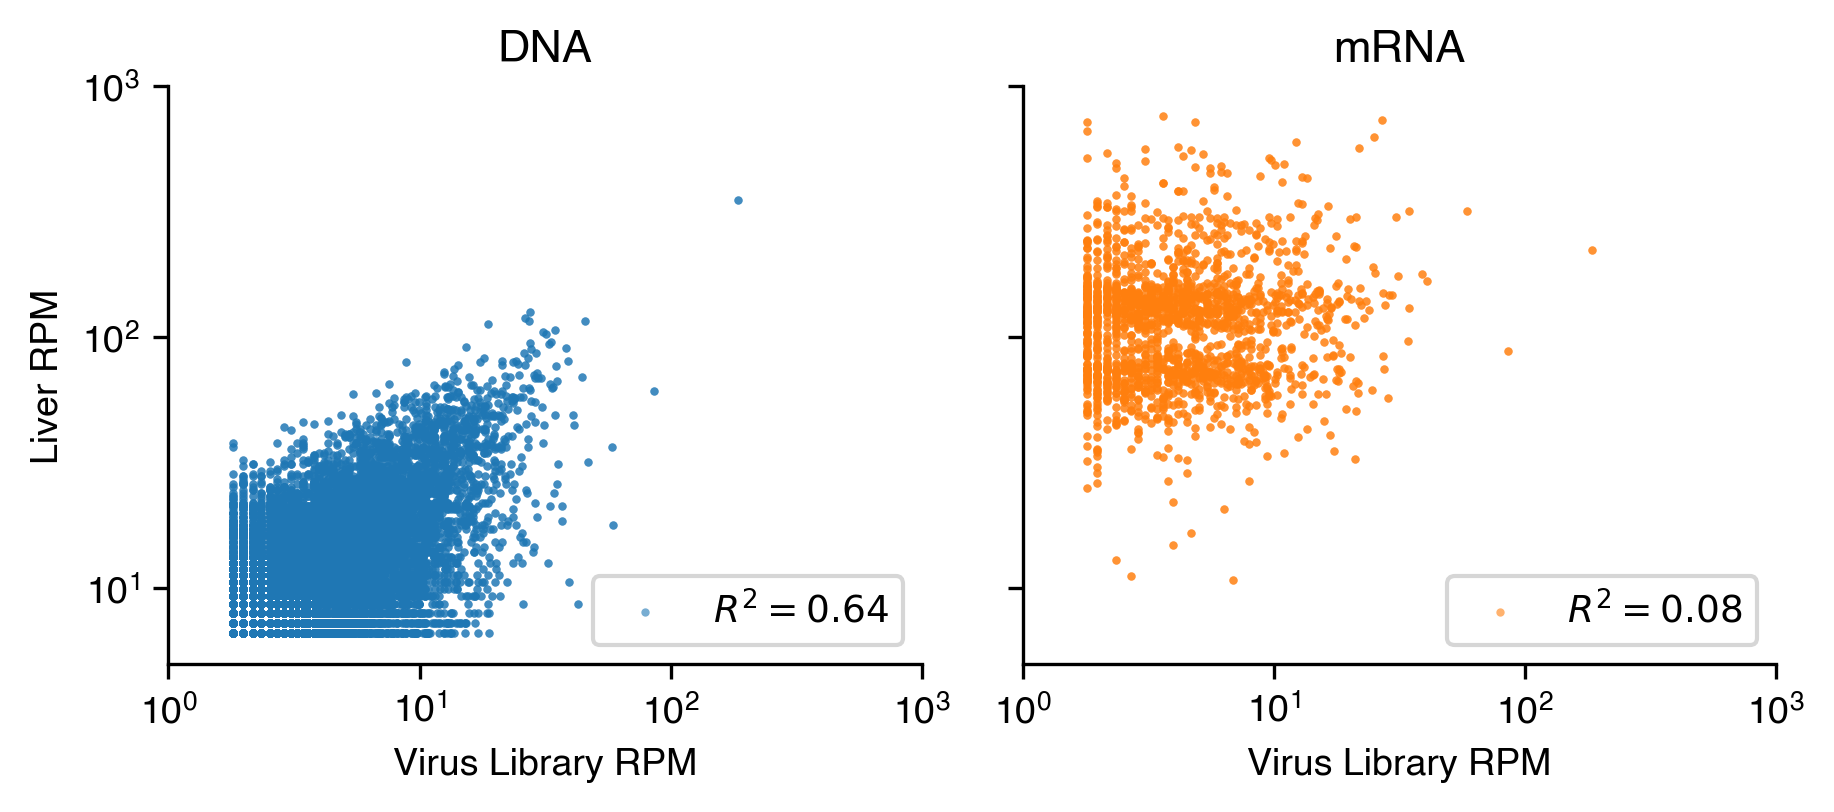

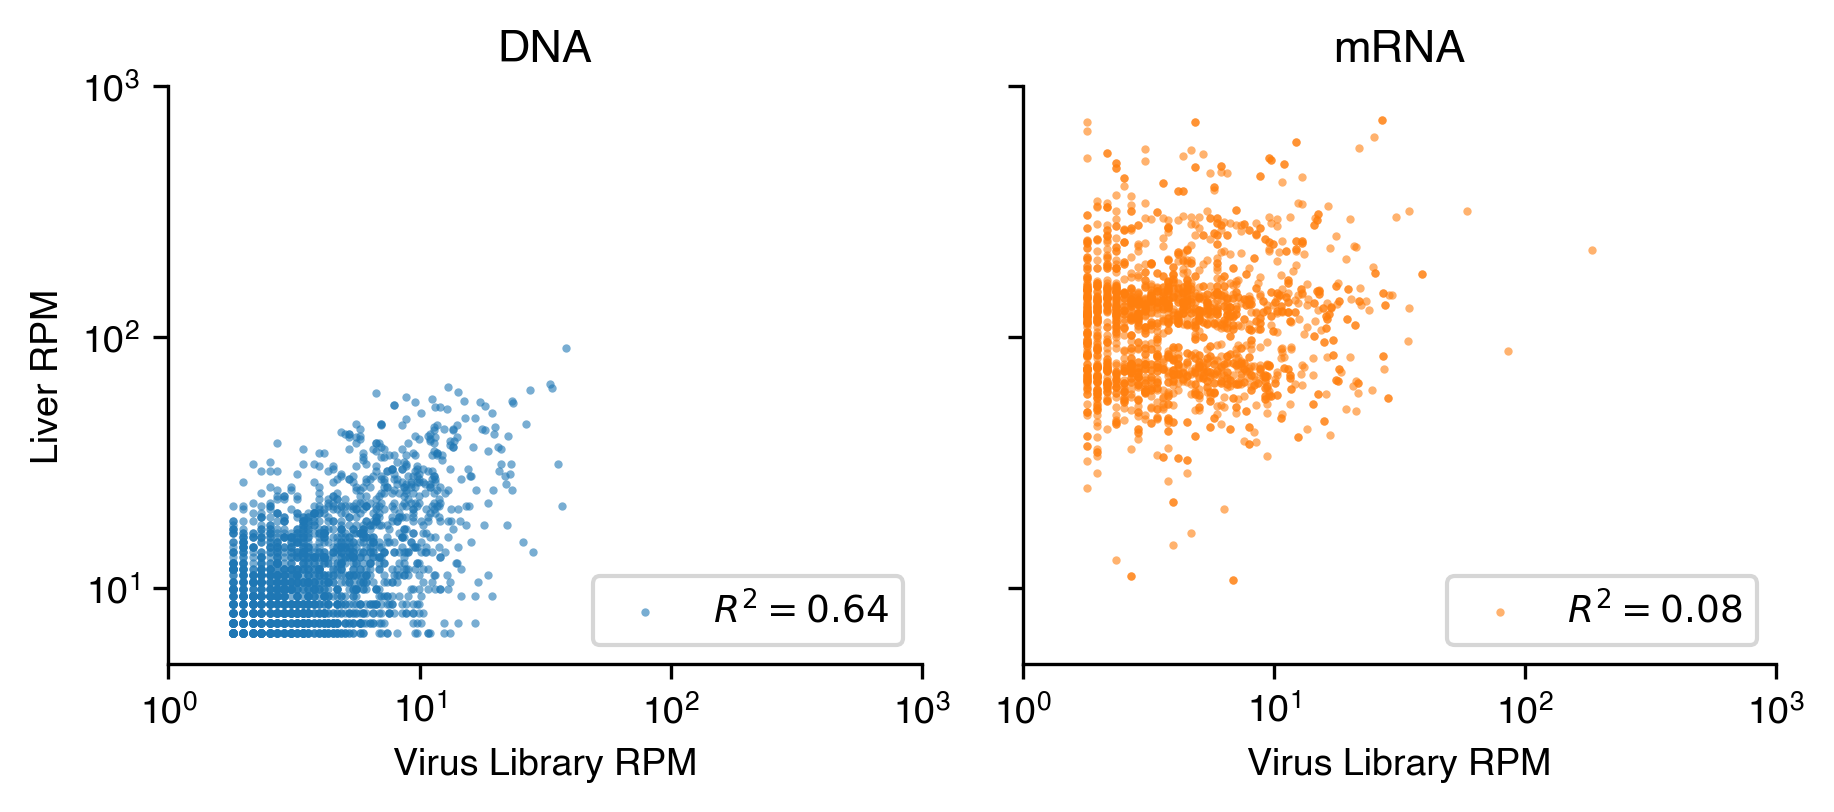

In [8]:
dnavl = liver_dna.merge(cmv_vl, on='seq', suffixes=('', '_vl'))[['seq', 'rpm', 'rpm_vl']]
mrnavl = liver_mrna.merge(cmv_vl, on='seq', suffixes=('', '_vl'))[['seq', 'rpm', 'rpm_vl']]
cmap = plt.get_cmap('tab10')


def scatter_comp(df, ax=None, title=None, color=None, downsample=None):
    ro = scipy.stats.linregress(df['rpm_vl'], df['rpm'])

    if downsample is not None:
        idx = random.sample(range(len(df)), min(len(df), downsample))
        df = df.loc[idx, :]
    ax.scatter(df['rpm_vl'], df['rpm'], linewidths=0, alpha=0.6, s=4, edgecolor=None, 
               label='$R^2 = {:.2f}$'.format(ro[2]), color=color)
    ax.set_xlabel('Virus Library RPM')
    ax.set_title(title)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal')
    ax.minorticks_off()
    ax.legend(loc='lower right')
    lims = np.array([2, 1e3])
    ax.set_xlim([1, 1e3])
    ax.set_ylim([5, 1e3])
    
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)
scatter_comp(dnavl, ax=axs[0], title='DNA')
scatter_comp(mrnavl, ax=axs[1], title='mRNA', color=tab10(1))
axs[0].set_ylabel('Liver RPM')


fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)
scatter_comp(dnavl, ax=axs[0], title='DNA', downsample=2000)
scatter_comp(mrnavl, ax=axs[1], title='mRNA', color=tab10(1), downsample=2000, )
axs[0].set_ylabel('Liver RPM')
plt.savefig('../figures/liver_dna_mrna_vl_correlation.downsample.svg')
plt.savefig('../figures/liver_dna_mrna_vl_correlation.downsample.png')

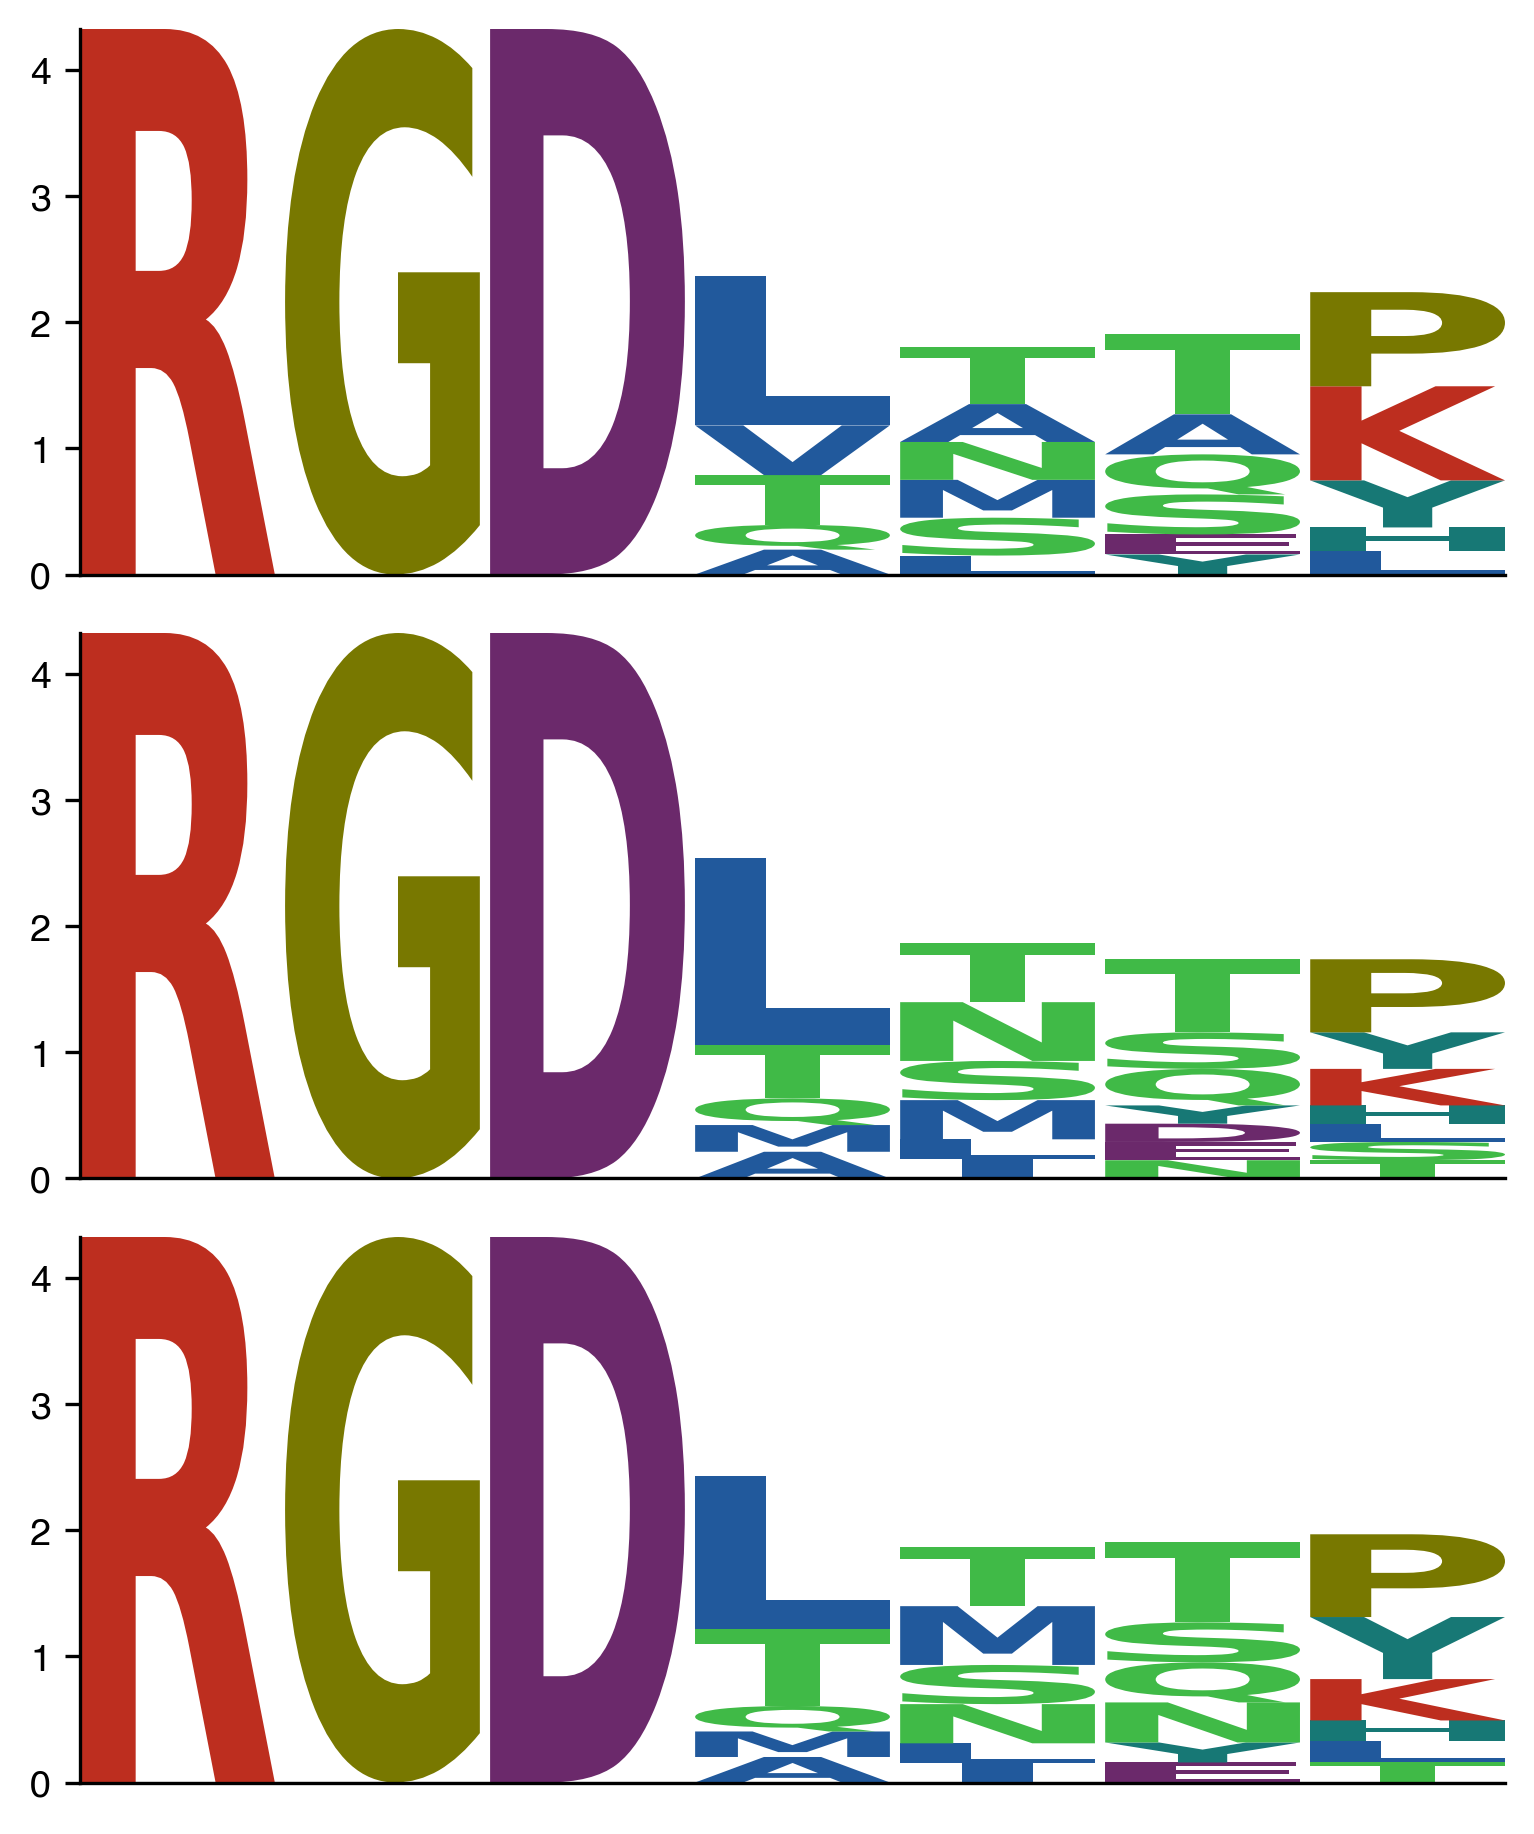

In [9]:
nmeth_wong_colorblind = {
        'GSTYC': '#E69F00',
        'QN': '#009E73',
        'KRH': '#D55E00',
        'DE': '#56B4E9',
        'AVLIPWFM': '#000000',
}
def plot_seqlogo(g, top=None, score_threshold=None, filename=None, seq_len=None, column=None, nnk_norm=None,
                 ic_scale=None, use_values=None, ax=None, color_scheme=None, extract_regex=None,
                 title=None):
    top = top if top is not None else 50
    seq_len = seq_len if seq_len is not None else 7
    column = column if column is not None else 'score'
    nnk_norm = nnk_norm if nnk_norm is not None else True
    ic_scale = ic_scale if ic_scale is not None else True
    use_values = use_values if use_values is not None else False
    color_scheme = color_scheme if color_scheme is not None else 'chemistry'
    # Don't consider seqs with a stop codon
    g = g[~g['aa'].str.contains('\*')].copy()
    if score_threshold:
        g = g.loc[g[column] >= score_threshold]
    else:
        g = g
    if top:
        g = g.head(top)

    if extract_regex:
        g['aa'] = g['aa'].str.extract(extract_regex).sum(axis=1)

    aa_letters = list(Bio.Data.IUPACData.protein_letters)
    if not use_values:
        chars = pd.DataFrame(g[['aa']].values.astype(str).view('<U1'), columns=list(range(seq_len)))
        c = chars.apply(pd.value_counts).T.reindex(columns=aa_letters, fill_value=0.) / len(chars)
    else:
        per_pos = []
        for i in range(seq_len):
            per_pos.append(g.groupby(i).sum()[column] / g.sum()[column])
        c = pd.DataFrame(per_pos, columns=aa_letters)

    if nnk_norm:
        for aa, n_codons in nnk_codon_counts.items():
            c[aa] /= n_codons

    pfm = c.reset_index().drop(columns=['index']).fillna(0)
    # Do normalization ourselves so logomaker doesn't spam print about it
    pfm = pfm.div(pfm.sum(axis=1), axis=0)
    pfm = logomaker.transform_matrix(pfm, from_type='probability', to_type='information')
    logo = logomaker.Logo(pfm, color_scheme=color_scheme, ax=ax)
    if not ax:
        ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    logo.style_xticks(anchor=0, spacing=1)
    ax.tick_params(axis='both', which='major')#, labelsize=6)
    if title is not None:
        ax.set_title(title)
    return logo

hits = pd.read_csv('../data/rgd_seqlogo/fig1d_sequence_logo_hits.csv')

fig, axs = plt.subplots(3, 1, figsize=(5, 6))

plot_seqlogo(hits['CK8'].rename('aa').to_frame(), ax=axs[0], nnk_norm=False, 
               color_scheme='NajafabadiEtAl2017')
plot_seqlogo(hits['MHCK7'].rename('aa').to_frame(), ax=axs[1], nnk_norm=False, 
              color_scheme='NajafabadiEtAl2017')
plot_seqlogo(hits['CK8 + MHCK7'].rename('aa').to_frame(), ax=axs[2], nnk_norm=False, 
              color_scheme='NajafabadiEtAl2017')

plt.savefig('../figures/rgd_seqlogo.svg')
plt.savefig('../figures/rgd_seqlogo.png')